In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os


## 简单的道具图像识别, 然后部署到安装上, 这是一个完整的流程,做出来一个简单的应用

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

## 编写一个我自己的custom dataset的模型训练

In [4]:
## 读取道具的 爬虫的数据映射
import json
with open("id_mapping_dict.json") as file:
    json_content = json.loads(file.read())

# 和键值对没有关系, 所以直接取就可以了
classes = {v['new_id']:v["zh"]+":"+v["desc"] for i, v in json_content.items() if v.get("new_id")!= None}
label_dict = {v['new_id']:v for i, v in json_content.items() if v.get("new_id")!=None}
# classes

In [5]:
# # ls cus_data/
# from PIL import Image
# dir_path = "cus_data/"
# image = Image.open("cus_data/0.png")
# print(image.size)
# image

# 增加7个随机的背景, 用来合成带背景的图片识别  
这样每个类别的对象就增加到7个这么多了.  

In [6]:
from PIL import Image
from tqdm import tqdm

# 打开背景图像和对象图像
def add_image_bg(bg_image_path, image_path, output_path):
    background = Image.open(bg_image_path)
#     background = background.resize((64, 64))
    background = background.resize((32, 32))  # 缩放到32, 32, 作为输入, 这样我们速度才能起来
    object_image = Image.open(image_path)
    background.paste(object_image, (0, 0), mask=object_image)

    # 保存叠加后的图像
    background.save(output_path, "PNG")
    return background

def plot_images(images:Image, images_per_row = 9, figsize=(5,5)):  # pil 的图片才能plot
    plt.figure(figsize=figsize)

    # 获取第一张图片的尺寸，假设所有图片尺寸都相同
    image_width, image_height = images[0].size

    if len(images) > images_per_row:
        # 计算总的行数
        total_rows = len(images) // images_per_row
        total_rows += 1 if len(images) % images_per_row > 0 else 0 # 有余数就多加一行就可以了
    else:
        images_per_row = len(images)
        total_rows = 1
        
    # 创建一个新的空白图片，尺寸为所有图片拼接后的尺寸
    canvas_width = images_per_row * image_width
    canvas_height = total_rows * image_height
    canvas = Image.new('RGB', (canvas_width, canvas_height))

    # 逐行逐列粘贴图片
    for i, image in enumerate(images):
        row = i // images_per_row
        col = i % images_per_row

        # 计算当前图片在画布上的位置
        left = col * image_width
        top = row * image_height

        # 粘贴图片
        canvas.paste(image, (left, top))
    plt.imshow(canvas)
    plt.show()

In [7]:
bg_files = [i for i in os.listdir("./cus_background/") if i.find(".")!=0]
bg_files[:10]

['bg_00003.png',
 'bg_00002.png',
 'bg_00001.png',
 'bg_00005.png',
 'bg_00011.png',
 'bg_00010.png',
 'bg_00004.png',
 'bg_00012.png',
 'bg_00006.png',
 'bg_00007.png']

In [8]:
# import os
# output_dir = "new_cus_data"
# os.makedirs(output_dir, exist_ok=True)
# bg_files = [i for i in os.listdir("./cus_background/") if i.find(".")!=0]
# meta_images = [i for i in os.listdir("./cus_data/") if i.find(".")!=0]
# meta_images.sort(key=lambda x: int(x.split(".png")[0]))
# meta_images
# print("总共数量:", len(meta_images))
# print("总共背景数量:", len(bg_files))

# new_meta_images = []
# for image in tqdm(meta_images):
#     for bg in bg_files:
#         bg_path = f"cus_background/{bg}"
#         image_path = f"cus_data/{image}"

#         output_name = image_path.split("/")[-1].strip("png") + bg_path.split("/")[-1]
#         output_path = os.path.join(output_dir, output_name)
#         result = add_image_bg(bg_path, image_path, output_path)
# #       plt.imshow(result)
# #         if len(new_meta_images) >= 30:
# #             continue
# #         else:
# #             new_meta_images.append(result)
            
        
# print("合成完毕")

# # 使用没有边缘模糊的进行训练

In [9]:
# class_len = len(new_meta_images)
# print(class_len)

In [10]:
# plot_images(new_meta_images, figsize=(10, 10))

In [11]:
import torch
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 构造一个模型

In [12]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)  # 计算公式是什么, 需要搞明白
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()
# print(f"device:{device}")
# net.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# # 定义损失函数 和优化器

In [13]:
# 检查transform的效果
from torchvision.transforms import ToTensor
        
transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.RandomCrop(size=(32, 32), padding=[3, 3, 3, 3]),

#         transforms.Resize((64, 64)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            [43.11019, 42.666084, 42.702415],
            [100.52347, 99.96471, 100.45631]
        )  # 对图片数据做正则化
    ])

In [14]:
# ## 检查一下transform的大概效果, 检查的时候也需要打开正则化, 才能显示正常
# import numpy as np
# check_images = []
# for i in range(9):
#     plt.figure(figsize=(1, 1))  # 设置图片尺寸为10x8英寸
#     path = f"new_cus_data/1.bg_0000{i+1}.png"
#     c_image = read_image(path, 
#                         torchvision.io.image.ImageReadMode.RGB)
#     c_image = transform(c_image)
#     npimg = c_image.numpy()
#     #     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     c_image =  np.transpose(npimg, (1, 2, 0))
#     check_images.append(c_image)
    
# # plot_images(check_images)
#     plt.imshow(c_image)
#     plt.title(c_image.shape)
#     plt.show()

# 此处 开始 00--------00 直接重新用vgg16做的

In [15]:
from torchvision.io import read_image

class IssacCustomDatasets(Dataset):
    def __init__(self, img_sort_files, 
                 img_dir, transform=None, 
                target_transform=None):
        self.img_labels = img_sort_files
        # 自定义标签关系, 此处需要排好序的
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):  # 作用是获得label 和 item 即可
        filename = self.img_labels[idx]        
        img_path = os.path.join(self.img_dir, filename)
        image = read_image(img_path, mode=torchvision.io.image.ImageReadMode.RGB)

        label = int(filename.split(".")[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [16]:
# meta_output_dir = "new_mini_20meta_dataset"
# os.makedirs(meta_output_dir, exist_ok=True)

from_dir = "new_cus_data"
need_move_images = os.listdir("new_cus_data/")
need_move_images = [i for i in need_move_images if int(i.split(".")[0]) ] # <= 19]  # 此处设定了 前20类
# need_move_images.sort(key=lambda x: int(x.split(".")[:1]))
need_move_images.sort(key=lambda x: f"{int(x.split('.')[0]):03d}" + f"{x.split('.')[1]}")
print(len(need_move_images))

10872


In [17]:
batch_size = 33 # 15改成了17 64x64 # 32x32 33

# batch_size = 64 # 试试 32x32的是不是可以
batch_size = 128 # 试试 32x32的是不是可以


# 需要已经排好序
# train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_mini_20meta_dataset/",
#                                     transform=transform)
# labels = list(range(len(os.listdir("cus_data"))))
train_dataset = IssacCustomDatasets(img_sort_files=need_move_images, img_dir="new_cus_data/",
                                    transform=transform)

## dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# test_loader = train_dataloader

In [18]:
len(need_move_images)

10872

### 完整类别的版本

In [19]:
from torchvision.models import vgg16
import torch.optim as optim
import numpy as np

## 大批量测试的版本

In [20]:
# 获取图片数据的 归一化数值
global_mean = []
global_std = []

for images, labels in train_dataloader:   # dataloader is a DataLoader instance with your dataset
    numpy_image = images.numpy()
    
    # Compute mean and std dev
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    global_mean.append(batch_mean)
    global_std.append(batch_std)

# Final mean and std (use np.mean instead of np.average)
global_mean = np.mean(global_mean, axis=0).tolist()
global_std = np.mean(global_std, axis=0).tolist()
print(global_mean)
print(global_std)

[0.2806248068809509, 0.12481743097305298, 0.07901351898908615]
[0.5795294642448425, 0.5000615119934082, 0.4844346344470978]


In [21]:
# 自定义读取透明背景png的图片
# 根据新的标准差和平均数, 重新运行dataloader
from torchvision.transforms import ToTensor
        
transform = transforms.Compose(
    [
        
        transforms.RandomCrop(size=(32, 32), padding=[2, 2, 2, 2]),
        transforms.RandomAffine(degrees=0, translate=None, scale=(0.9, 1.1), shear=None),  
        # 随机放大或者缩小一点点

        # transforms.ToTensor(),
#         transforms.Resize((64, 64)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            saturation=0.15,
            hue=0.15),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            global_mean,
            global_std
        )  # 对图片数据做正则化
    ])


# 需要已经排好序
# train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_mini_20meta_dataset/",
#                                     transform=transform)
# labels = list(range(len(os.listdir("cus_data"))))
train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_cus_data/", transform=transform)

## dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# test_loader = train_dataloader

In [22]:
total_classes = list(set([i.split(".")[0] for i in need_move_images]))
total_classes_num = len(total_classes)

In [23]:
## 大批量测试
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

# net = vgg16(num_classes=total_classes_num)  # 这个倒是完整的
# net.to(device)  # 重建一个模型, 初始化一个  或者我直接用 64 不用于训练模型

class VGG16_S(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_S, self).__init__()
        model = vgg16(pretrained=True)  # 控制变量法, 晚点再看看 True的效果如何 , 试一下 继承特征的
        self.features = model.features  # 只取了feature
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # 修改此处的第一个参数
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x
    
    
# 改一下 更小的 32x32的输入
class VGG16_S(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_S, self).__init__()
        model = vgg16(pretrained=True)  # 控制变量法, 晚点再看看 True的效果如何 , 试一下 继承特征的
        self.features = model.features  # 只取了feature
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  # 修改此处的第一个参数
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x
      

In [24]:
## 我的目标是解决这个任务, 而不是 玩 无尽的循环游戏,并且没能获得快乐

In [25]:
1/0

ZeroDivisionError: division by zero

In [ ]:
%%time
# 训练模型

# 如果要继续训练的话, 就用这个
# model_path = "20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth"  # 这个才是最新的
# net = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本
# net.load_state_dict(torch.load(model_path))  # 不用百分百的

# 如果不根据之前的进行训练就读取这个
net = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)  # 加入了l2正则化

check_iter = 10 # train check batch size 
train_epoch = 25
prefix = f"20240128_full_32x32_clear_{total_classes_num}class_l2_2-"

print("batch_size", batch_size)
for epoch in range(train_epoch):
    net.train()  # 每个epoch 后切换训练模式, 那么会不会保d留之前的训练权重呢?
    
    progress_bar = tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader))
    for i, data in progress_bar:
        inputs, labels = data  # 必须要float 归一化? 浮点类型.
        inputs, labels = inputs.float().to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)  # 这一步, 运行有问题, 这是为什么呢, 检查一下图片格式

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f'epoch:{epoch}, loss: {loss / batch_size:.3f}')
    
    if epoch % 1 == 0:  # 每两个epoch进行一次验证
        print("开始验证....")
        net.eval()
        correct = 0  # 记录正确预测的数量
        total = 0  # 总的样本数
        with torch.no_grad():
            
            progress_bar2 = tqdm(enumerate(train_dataloader, 0), total=int(len(train_dataloader) * 0.4))
            for i, data in progress_bar2:
                if i >= int(len(train_dataloader) * 0.4):
                    break
                inputs, labels = data
                inputs, labels = inputs.float().to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)  # 实际的样本数
                correct += (predicted == labels).sum().item()  # 正确预测的样本数
        
        accuracy = round(correct / total * 100, 3)  # 计算准确率
        print(f'epoch: {epoch}, Accuracy: {accuracy:.3f}')
        if accuracy >= 60:  # 太小的根本没比较保存
            save_model_path = f"{prefix}_vgg16_{epoch}_{accuracy}.pth"
            torch.save(net.state_dict(), save_model_path)
            print(f"model save: ", save_model_path)
        
    torch.cuda.empty_cache()
print('Finished Training')

save_model_path = f"{prefix}_vgg16_{epoch}_{accuracy}.pth"
torch.save(net.state_dict(), save_model_path)
print(f"model save: ", save_model_path)

In [ ]:
# loss 有问题, 就是训练数据有问题, 

epoch:24, Accuracy: 92.196  
model save:  20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth  
Finished Training  
model save:  20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth  
CPU times: user 4h 41min 37s, sys: 28min 20s, total: 5h 9min 57s  
Wall time: 1h 19min 47s  

model save:  20240126__vgg16_19_100.0.pth  
CPU times: user 22min 21s, sys: 3min 49s, total: 26min 11s  
Wall time: 49min 32s  

Finished Training  
model save:  20240127_full_64x64_718class_continue__vgg16_4_99.37984496124031.pth  
CPU times: user 43min 38s, sys: 3min 48s, total: 47min 26s  
Wall time: 11min 37s  

In [ ]:
## 使用resnet 101 进行训练, 更深的网络,但是速度更快? 验证一下.

1/0

## 用ResNet网络进行训练&验证对比效果

In [31]:
%%time
# 训练模型

# 加载ResNet101模型
net = torchvision.models.resnet101(pretrained=True)
num_features = net.fc.in_features

# 增加 dropout
net.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),   # 增加 dropout避免太快过拟合
    torch.nn.Linear(num_features, total_classes_num)
)
# 单层卷积, 替代了vgg的4096个全连接层,深,但是速度还更快
net.to(device)

model.eval()  # 验证模块

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)  # 加入了l2正则化

check_iter = 10 # train check batch size 
train_epoch = 25
prefix = f"20240201_full_32x32_clear_{total_classes_num}class_l2_2-"

print("batch_size", batch_size)
for epoch in range(train_epoch):
    net.train()  # 每个epoch 后切换训练模式, 那么会不会保d留之前的训练权重呢?
    
    progress_bar = tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader))
    for i, data in progress_bar:
        inputs, labels = data  # 必须要float 归一化? 浮点类型.
        inputs, labels = inputs.float().to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)  # 这一步, 运行有问题, 这是为什么呢, 检查一下图片格式

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f'epoch:{epoch}, loss: {loss / batch_size:.3f}')
    
    if epoch % 1 == 0:  # 每两个epoch进行一次验证
        print("开始验证....")
        net.eval()
        correct = 0  # 记录正确预测的数量
        total = 0  # 总的样本数
        with torch.no_grad():
            
            progress_bar2 = tqdm(enumerate(train_dataloader, 0), total=int(len(train_dataloader) * 0.4))
            for i, data in progress_bar2:
                if i >= int(len(train_dataloader) * 0.4):
                    break
                inputs, labels = data
                inputs, labels = inputs.float().to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)  # 实际的样本数
                correct += (predicted == labels).sum().item()  # 正确预测的样本数
        
        accuracy = round(correct / total * 100, 3)  # 计算准确率
        print(f'epoch: {epoch}, Accuracy: {accuracy:.3f}')
        if accuracy >= 60:  # 太小的根本没比较保存
            save_model_path = f"{prefix}_resnet101_{epoch}_{accuracy}.pth"
            torch.save(net.state_dict(), save_model_path)
            print(f"model save: ", save_model_path)
        
    torch.cuda.empty_cache()
print('Finished Training')

save_model_path = f"{prefix}_resnet101_{epoch}_{accuracy}.pth"
torch.save(net.state_dict(), save_model_path)
print(f"model save: ", save_model_path)

batch_size 128


epoch:0, loss: 0.049: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:11<00:00,  2.25s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.78it/s]


epoch: 0, Accuracy: 9.605


epoch:1, loss: 0.035: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [02:57<00:00,  2.09s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:23<00:00,  1.42it/s]


epoch: 1, Accuracy: 50.138


epoch:2, loss: 0.019: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [02:50<00:00,  2.01s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.91it/s]


epoch: 2, Accuracy: 82.560
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_2_82.56.pth


epoch:3, loss: 0.009: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [02:42<00:00,  1.91s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:18<00:00,  1.88it/s]


epoch: 3, Accuracy: 95.887
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_3_95.887.pth


epoch:4, loss: 0.005: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [02:45<00:00,  1.95s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.90it/s]


epoch: 4, Accuracy: 96.507
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_4_96.507.pth


epoch:5, loss: 0.003: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [02:54<00:00,  2.05s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.94it/s]


epoch: 5, Accuracy: 99.058
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_5_99.058.pth


epoch:6, loss: 0.002: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:02<00:00,  2.14s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.91it/s]


epoch: 6, Accuracy: 99.288
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_6_99.288.pth


epoch:7, loss: 0.002: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:03<00:00,  2.16s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:18<00:00,  1.86it/s]


epoch: 7, Accuracy: 99.517
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_7_99.517.pth


epoch:8, loss: 0.001: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [27:43<00:00, 19.57s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.72it/s]


epoch: 8, Accuracy: 99.150
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_8_99.15.pth


epoch:9, loss: 0.001: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [02:59<00:00,  2.12s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.74it/s]


epoch: 9, Accuracy: 99.127
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_9_99.127.pth


epoch:10, loss: 0.001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:03<00:00,  2.16s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:20<00:00,  1.64it/s]


epoch: 10, Accuracy: 99.311
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_10_99.311.pth


epoch:11, loss: 0.001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:06<00:00,  2.19s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:21<00:00,  1.61it/s]


epoch: 11, Accuracy: 99.288
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_11_99.288.pth


epoch:12, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:17<00:00,  2.33s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:21<00:00,  1.56it/s]


epoch: 12, Accuracy: 99.449
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_12_99.449.pth


epoch:13, loss: 0.001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:49<00:00,  2.70s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:23<00:00,  1.43it/s]


epoch: 13, Accuracy: 99.357
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_13_99.357.pth


epoch:14, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [03:59<00:00,  2.82s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:24<00:00,  1.39it/s]


epoch: 14, Accuracy: 99.563
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_14_99.563.pth


epoch:15, loss: 0.001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:05<00:00,  2.89s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:25<00:00,  1.33it/s]


epoch: 15, Accuracy: 98.736
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_15_98.736.pth


epoch:16, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:09<00:00,  2.94s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:24<00:00,  1.39it/s]


epoch: 16, Accuracy: 99.219
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_16_99.219.pth


epoch:17, loss: 0.001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:12<00:00,  2.97s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:24<00:00,  1.38it/s]


epoch: 17, Accuracy: 99.403
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_17_99.403.pth


epoch:18, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:11<00:00,  2.96s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:25<00:00,  1.34it/s]


epoch: 18, Accuracy: 98.966
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_18_98.966.pth


epoch:19, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:08<00:00,  2.92s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:26<00:00,  1.29it/s]


epoch: 19, Accuracy: 98.851
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_19_98.851.pth


epoch:20, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:06<00:00,  2.90s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:23<00:00,  1.44it/s]


epoch: 20, Accuracy: 99.380
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_20_99.38.pth


epoch:21, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:09<00:00,  2.94s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:25<00:00,  1.35it/s]


epoch: 21, Accuracy: 99.219
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_21_99.219.pth


epoch:22, loss: 0.001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:07<00:00,  2.91s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:25<00:00,  1.36it/s]


epoch: 22, Accuracy: 99.104
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_22_99.104.pth


epoch:23, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:10<00:00,  2.95s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:23<00:00,  1.42it/s]


epoch: 23, Accuracy: 99.173
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_23_99.173.pth


epoch:24, loss: 0.002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [04:05<00:00,  2.89s/it]


开始验证....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:23<00:00,  1.45it/s]


epoch: 24, Accuracy: 98.874
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_24_98.874.pth
Finished Training
model save:  20240201_full_32x32_clear_906class_l2_2-_resnet101_24_98.874.pth
CPU times: user 3h 15min 18s, sys: 42min 14s, total: 3h 57min 33s
Wall time: 2h 2min 38s


In [ ]:
## 大概40个epoch就可以了?

In [32]:
ls | grep pth

20240201_full_32x32_clear_906class_l2_2-_resnet101_10_99.311.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_11_99.288.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_12_99.449.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_13_99.357.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_14_99.563.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_15_98.736.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_16_99.219.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_17_99.403.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_18_98.966.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_19_98.851.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_1_73.782.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_20_99.38.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_21_99.219.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_22_99.104.pth
20240201_full_32x32_clear_906class_l2_2-_resnet101_23_99.173.pth
20240201_full_32x32_clear_9

In [40]:
# 验证一下 resnet模型效果

# model_path = "20240201_full_32x32_clear_906class_l2_2-_resnet101_3_97.266.pth"  # 这个效果也不错 19, 看第一/第二个
model_path = "20240201_full_32x32_clear_906class_l2_2-_resnet101_8_99.15.pth"
model_path = "model/20240201_full_32x32_clear_906class_l2_2-_resnet101_9_99.127.pth"

model = torchvision.models.resnet101(pretrained=True)
# 将全连接层修改为10分类
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),   # 并且增加多一个这个 dropout
    torch.nn.Linear(num_features, total_classes_num)
)
# model.fc = torch.nn.Linear(num_features, total_classes_num)  
# 单层卷积, 替代了vgg的4096个全连接层,深,但是速度还更快
model.to(device)
model.load_state_dict(torch.load(model_path))  # 不用百分百的


# model = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本
# model.load_state_dict(torch.load(model_path))  # 不用百分百的

def get_real_label(class_index):
    return label_dict[class_index]

def eval_predict(model, image_path):
    image = read_image(image_path, mode=torchvision.io.image.ImageReadMode.RGB)
    inner_transform = transforms.Compose(
    [
#         transforms.Resize((64, 64)), 
        transforms.Resize((32, 32)), 
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            global_mean,
            global_std
        )  # 对图片数据做正则化
    ])
    model.eval()
    timg = inner_transform(image)
    timg = timg.to(device)
    timg1 = timg.unsqueeze(0)
    result = model(timg1)
    _, predicted = torch.max(result, 1)
    get_real_label(predicted.item())
    return result, predicted

26
real label:  test_00010.png
Finger! 手指！: 61.74%
Orphan Socks 孤儿的袜子: 2.05%
Milk! 牛奶！: 1.51%
Placebo 安慰剂: 1.2%
Monstro's Tooth 萌死戳的牙: 1.07%
God's Flesh 神体蘑菇: 0.69%
Purgatory 炼狱恶鬼: 0.64%
Clear Rune 透明符文: 0.63%
Mom's Pad 妈妈的卫生巾: 0.55%
Duality 二元性: 0.51%


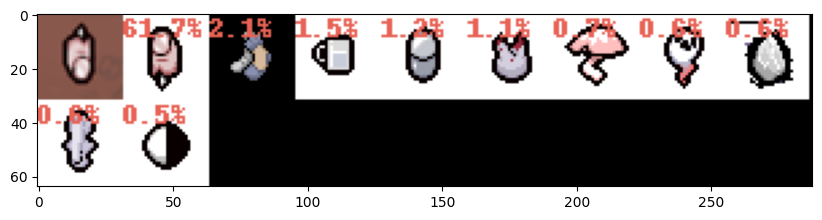


----------------------------------------------
real label:  test_00004.png
Guppy's Tail 嗝屁猫的尾巴: 8.56%
Smelter 熔炉: 1.76%
The Mulligan 虫群复击: 1.49%
Lunch 午餐: 1.07%
Lazarus' Rags 拉撒路的绷带: 0.96%
Skatole 粪臭素: 0.79%
Steven 史蒂文: 0.79%
Dead Tooth 烂牙: 0.77%
Shoop da Whoop! 嗖-哒-呜！: 0.75%
Slipped Rib 滑肋骨: 0.73%


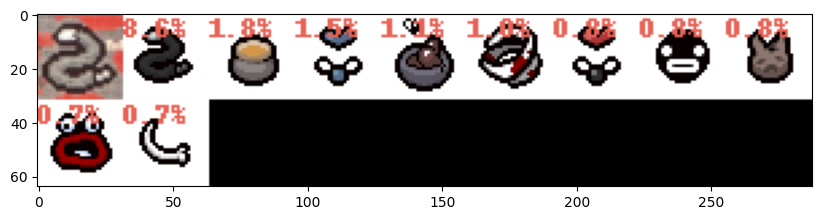


----------------------------------------------
real label:  test_00005.png
Mother's Kiss 母亲的吻: 7.68%
Ring Cap 火药圈: 4.72%
Wooden Nickel 木制镍币: 3.49%
Poker Chip 筹码: 2.72%
Kidney Bean 腰豆: 2.42%
Heartbreak 心碎: 2.36%
Eye of Belial 彼列之眼: 1.83%
Psy Fly 灵能苍蝇: 1.64%
Number Magnet 数字冰箱贴: 1.54%
Stem Cells 干细胞: 1.21%


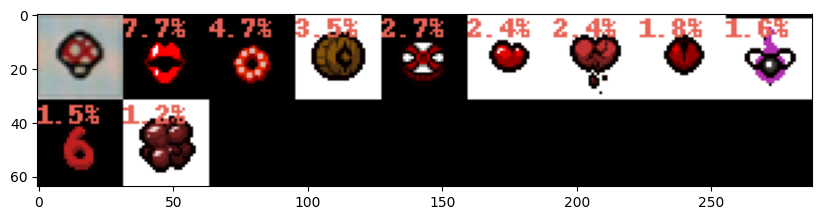


----------------------------------------------
real label:  test_00011.png
BBF 大美蝇: 5.29%
The Twins 双胞胎: 4.57%
Head of Krampus 坎卜斯的头: 2.6%
Esau Jr. 小以扫: 2.5%
Technology 2 科技II: 1.57%
Psy Fly 灵能苍蝇: 1.38%
Panic Button 紧急按钮: 0.96%
Sacred Heart 圣心: 0.91%
Berserk! 狂怒！: 0.82%
Lil Abaddon 亚巴顿宝宝: 0.81%


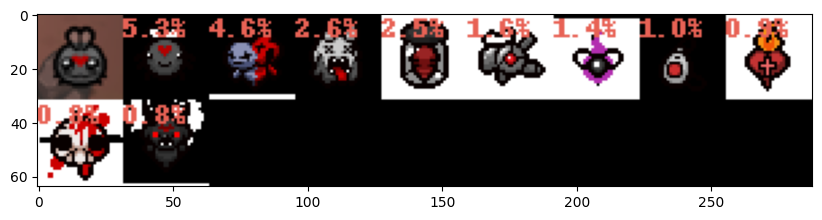


----------------------------------------------
real label:  test_00007.png
My Shadow 我的影子: 20.61%
Halo of Flies 苍蝇光环: 9.05%
Skatole 粪臭素: 3.66%
The Mulligan 虫群复击: 2.82%
Judas' Shadow 犹大的影子: 2.65%
Chaos 混沌: 0.91%
TMTRAINER 错误技: 0.67%
Brimstone 硫磺火: 0.63%
Doctor's Remote 胎儿博士的遥控器: 0.6%
The Swarm 虫群: 0.56%


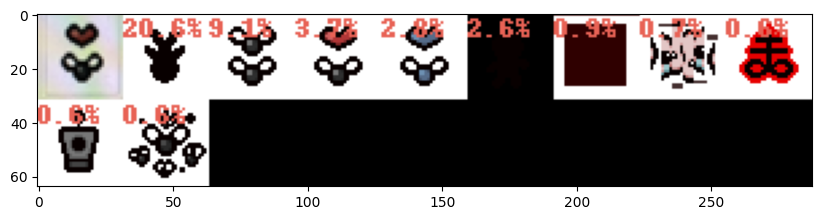


----------------------------------------------
real label:  test_00013.png
Ouija Board 通灵板: 76.68%
Prayer Card 祈祷卡: 1.59%
Kid's Drawing 儿童涂鸦: 1.25%
False PHD 伪造药学博士证: 0.55%
Keeper's Bargain 店主的协议: 0.42%
Soy Milk 豆奶: 0.39%
Store Credit 商店积分: 0.23%
Super Bandage 超级绷带: 0.23%
Mysterious Paper 神秘纸片: 0.2%
Key Piece 2 钥匙碎片2: 0.16%


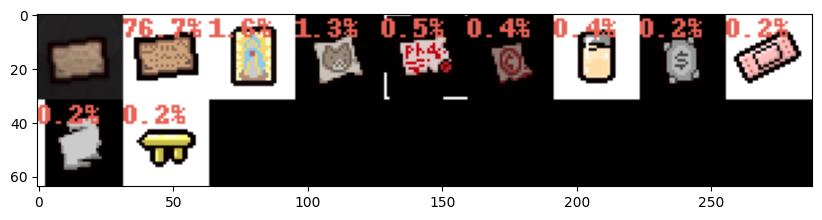


----------------------------------------------
real label:  test_00012.png
The Belt 皮带: 75.95%
RC Remote 赛车遥控器: 0.74%
Jumper Cables 跨接电缆: 0.45%
Schoolbag 书包: 0.37%
Cancer 癌症: 0.27%
The Necronomicon 死灵之书: 0.27%
Infestation 2 害虫横行II: 0.26%
Clicker 遥控器: 0.19%
Sacrificial Altar 祭坛: 0.18%
A Pony 小黑马: 0.18%


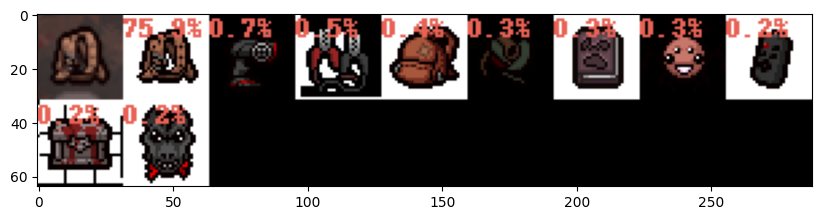


----------------------------------------------
real label:  test_00006.png
Broken Shovel 铲子碎片: 4.61%
Doctor's Remote 胎儿博士的遥控器: 4.22%
Locust of Death 死亡蝗虫: 2.19%
My Shadow 我的影子: 2.13%
Crow Heart 乌鸦的心: 1.97%
Judas' Shadow 犹大的影子: 1.96%
Wooden Cross 木十字架: 1.68%
Synthoil 合成油脂: 1.66%
Broken Padlock 损坏的挂锁: 1.4%
The Nail 钉子: 1.33%


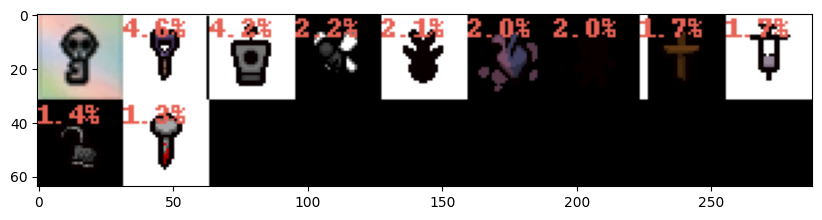


----------------------------------------------
real label:  test_00016.png
Goat Head 山羊头: 83.96%
Dessert 甜点: 1.68%
Best Friend 最好的朋友: 0.56%
Tinytoma 小畸胎瘤: 0.35%
Dad's Note 爸爸的便条: 0.3%
Black Lotus 黑莲花: 0.23%
Dead Bird 死鸟: 0.21%
Brimstone Bombs 硫磺火炸弹: 0.21%
Birthright 长子名分: 0.19%
Punching Bag 受气包: 0.19%


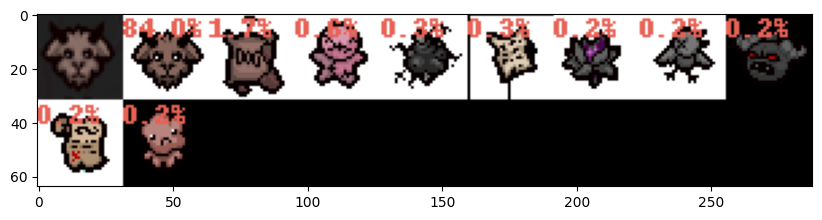


----------------------------------------------
real label:  test_00017.png
The Wiz 蠢巫帽: 86.86%
Lil Spewer 呕吐虫宝宝: 0.25%
My Little Unicorn 彩虹独角兽: 0.23%
Magic Skin 玄奇驴皮: 0.18%
Found Soul 复得游魂: 0.15%
Glyph of Balance 平衡符号: 0.12%
Orphan Socks 孤儿的袜子: 0.12%
Isaac's Head 以撒的头: 0.12%
Ghost Pepper 断魂椒: 0.11%
God's Flesh 神体蘑菇: 0.1%


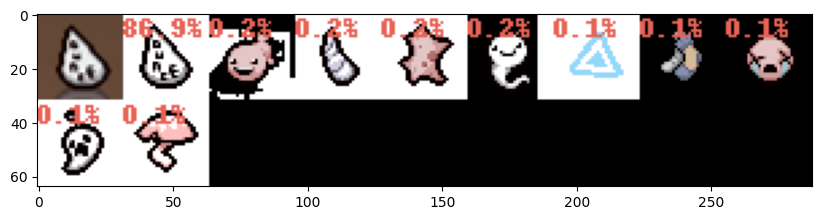


----------------------------------------------
real label:  test_00003.png
Missing Page 2 遗失的书页2: 12.05%
Missing Poster 寻人启事: 5.5%
Contract from Below 地狱契约: 3.4%
Death Certificate 死亡证明: 2.65%
The Polaroid 全家福: 2.09%
Pageant Boy 盛装男孩: 1.86%
False PHD 伪造药学博士证: 1.55%
Adoption Papers 领养协议书: 1.24%
Humbleing Bundle 慈善捆绑包: 1.16%
The Pact 契约: 1.15%


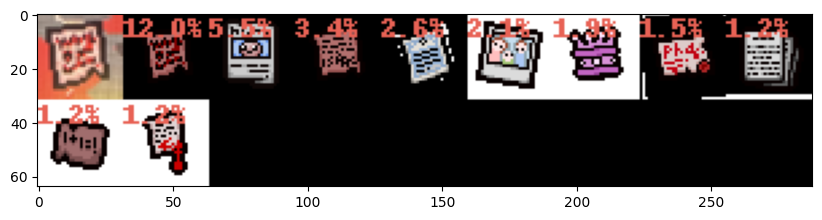


----------------------------------------------
real label:  test_00015.png
Latch Key 弹簧锁钥匙: 10.73%
Safety Pin 安全别针: 7.46%
Crystal Key 水晶钥匙: 4.72%
Marrow 骨髓: 2.16%
Potato Peeler 土豆削皮刀: 2.08%
Stapler 订书机: 2.07%
Death's List 死神名册: 1.53%
Spear Of Destiny 命运之矛: 1.26%
Endless Nameless 无名无尽: 1.21%
Scissors 剪刀: 1.05%


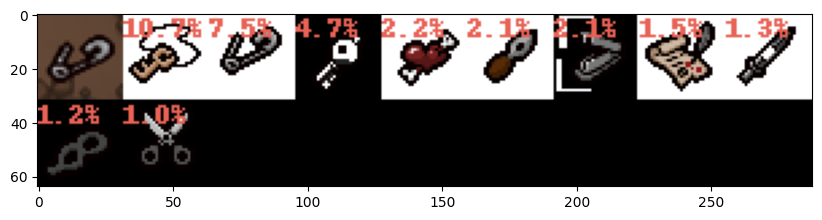


----------------------------------------------
real label:  test_00001.png
Leech 水蛭: 45.83%
Death's Touch 死神之触: 2.23%
Flat Penny 扁平硬币: 2.23%
Vasculitis 血管炎: 1.27%
Knife Piece 2 菜刀碎片2: 1.01%
Guppy's Collar 嗝屁猫的项圈: 0.93%
Torn Pocket 破损的口袋: 0.87%
Dog Tooth 狗牙: 0.59%
Mom's Underwear 妈妈的内裤: 0.47%
Meconium 胎粪: 0.46%


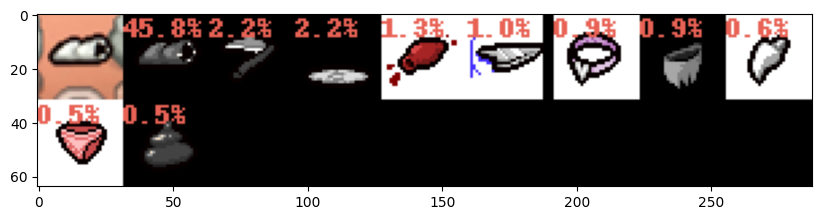


----------------------------------------------
real label:  test_00014.png
Fruit Cake 水果蛋糕: 81.72%
Plan C 计划C: 2.97%
Dead Eye 死亡之眼: 0.73%
Eye of Belial 彼列之眼: 0.44%
Spindown Dice 计数二十面骰: 0.43%
Brown Nugget 棕色粪块: 0.42%
Wooden Nickel 木制镍币: 0.37%
Maw Of The Void 虚空之喉: 0.36%
The Halo 光环: 0.26%
Bloody Gust 嗜血腥风: 0.25%


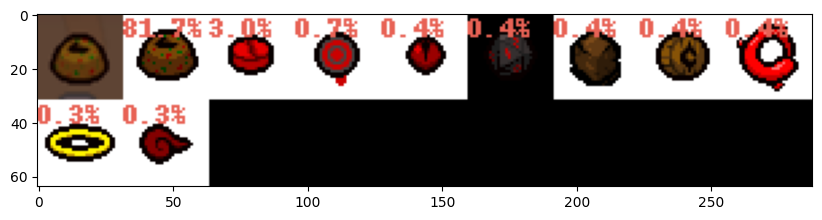


----------------------------------------------
real label:  test_00019.png
Match Book 火柴盒: 93.66%
Polished Bone 抛光骨头: 0.1%
Found Soul 复得游魂: 0.08%
Sacrificial Dagger 献祭匕首: 0.07%
God's Flesh 神体蘑菇: 0.07%
Mom's Knife 妈妈的菜刀: 0.07%
Finger! 手指！: 0.06%
Sworn Protector 宣誓守护者: 0.05%
Lil Spewer 呕吐虫宝宝: 0.05%
Orphan Socks 孤儿的袜子: 0.04%


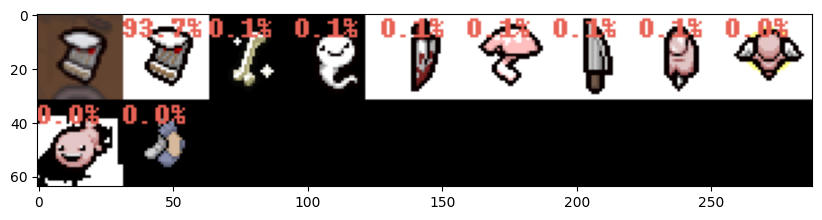


----------------------------------------------
real label:  test_00025.png
Monster Manual 怪物手册: 81.8%
How to Jump 跳跃教程: 1.63%
Ipecac 吐根酊: 0.84%
R Key R键: 0.6%
Anarchist Cookbook 无政府主义者食谱: 0.5%
Prayer Card 祈祷卡: 0.39%
Mega Mush 超级蘑菇: 0.35%
Book of Revelations 启示录: 0.25%
Curse of the Tower 塔之诅咒: 0.22%
The Battery 蓄电池: 0.18%


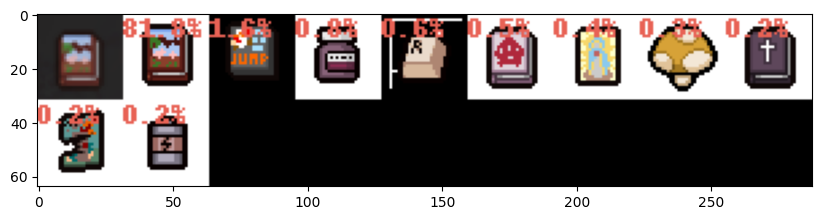


----------------------------------------------
real label:  test_00024.png
False PHD 伪造药学博士证: 50.11%
PHD 药学博士证: 1.71%
Bible Tract 圣经小册: 1.69%
Ipecac 吐根酊: 1.52%
The Pact 契约: 1.49%
NO! 不！: 1.15%
Ouija Board 通灵板: 0.94%
Keeper's Bargain 店主的协议: 0.92%
Dad's Note 爸爸的便条: 0.91%
Anarchist Cookbook 无政府主义者食谱: 0.61%


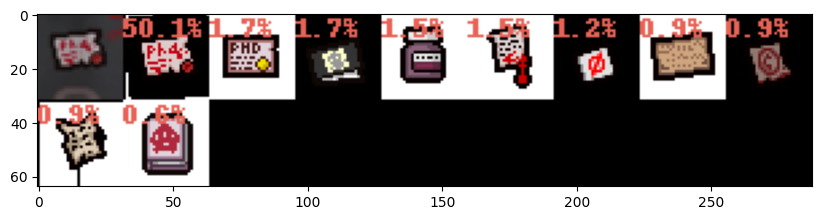


----------------------------------------------
real label:  test_00018.png
Match Book 火柴盒: 82.98%
God's Flesh 神体蘑菇: 0.41%
Finger! 手指！: 0.35%
Polished Bone 抛光骨头: 0.25%
Orphan Socks 孤儿的袜子: 0.21%
Found Soul 复得游魂: 0.2%
Divorce Papers 离婚协议书: 0.19%
Mom's Knife 妈妈的菜刀: 0.17%
A Bar of Soap 肥皂: 0.16%
Lil Spewer 呕吐虫宝宝: 0.15%


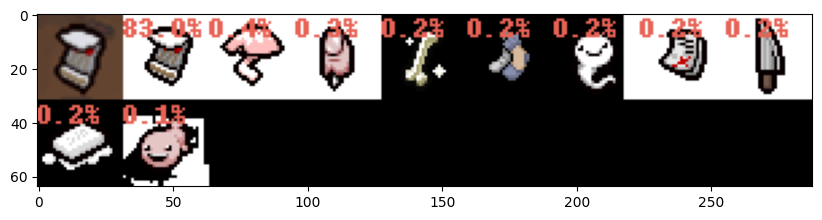


----------------------------------------------
real label:  test_00026.png
Analog Stick 模拟摇杆: 41.49%
Sack of Pennies 硬币袋: 4.74%
Metal Plate 金属板: 4.26%
Bum Friend 乞丐朋友: 2.2%
Dark Bum 黑暗乞丐: 1.94%
Bumbo 乞丐宝: 1.88%
Key Bum 钥匙乞丐: 1.33%
Dim Bulb 暗灯泡: 1.25%
Little Chubby 小胖蛆: 0.78%
Strawman 稻草人: 0.78%


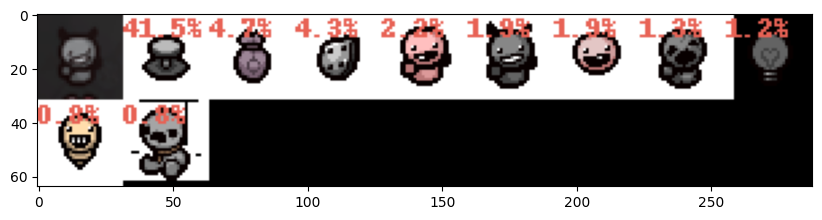


----------------------------------------------
real label:  test_00027.png
Leech 水蛭: 90.22%
Baby-Bender 儿童弯勺: 0.34%
Burnt Penny 焦灼硬币: 0.2%
Teardrop Charm 泪滴护符: 0.19%
Torn Pocket 破损的口袋: 0.19%
Meconium 胎粪: 0.15%
Guppy's Collar 嗝屁猫的项圈: 0.14%
Death's Touch 死神之触: 0.14%
Vasculitis 血管炎: 0.12%
Lucky Rock 幸运石: 0.12%


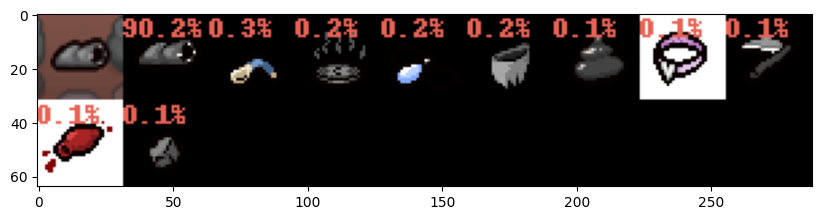


----------------------------------------------
real label:  test_00023.png
False PHD 伪造药学博士证: 82.53%
NO! 不！: 1.08%
PHD 药学博士证: 0.85%
The Pact 契约: 0.56%
Crack Jacks 琥珀爆米花: 0.54%
Bible Tract 圣经小册: 0.47%
Ouija Board 通灵板: 0.32%
Coupon 代金券: 0.31%
Kid's Drawing 儿童涂鸦: 0.25%
Dad's Note 爸爸的便条: 0.22%


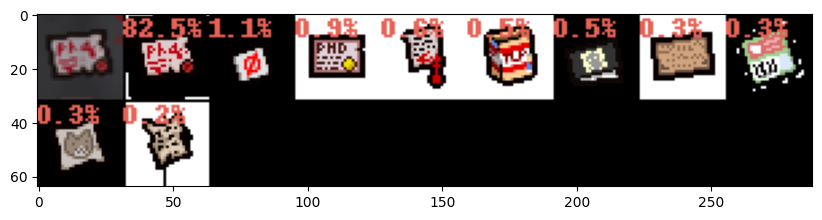


----------------------------------------------
real label:  test_00022.png
Dinner 正餐: 69.45%
Supper 晚餐: 1.7%
Echo Chamber 回声室: 0.5%
9 Volt 9伏特: 0.49%
Tooth Picks 牙签: 0.47%
Jacob's Ladder 雅各布天梯: 0.35%
Hairpin 发夹: 0.35%
Panic Button 紧急按钮: 0.32%
Tooth and Nail 肉中刺: 0.29%
Lunch 午餐: 0.23%


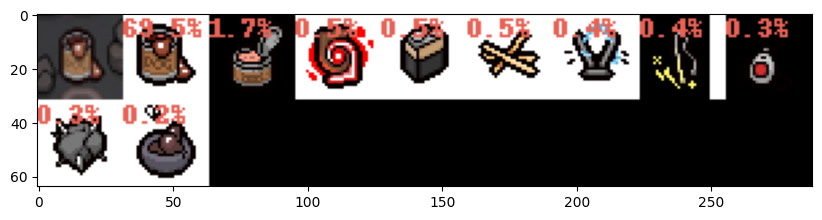


----------------------------------------------
real label:  test_00020.png
Match Stick 火柴棍: 73.1%
Sacrificial Dagger 献祭匕首: 1.21%
The Nail 钉子: 0.75%
Isaac's Fork 以撒的叉子: 0.72%
Finger Bone 指骨: 0.38%
The Hourglass 沙漏: 0.35%
Polished Bone 抛光骨头: 0.31%
Spirit Sword 英灵剑: 0.28%
Wooden Spoon 木头勺子: 0.27%
Act of Contrition 痛悔短祷: 0.21%


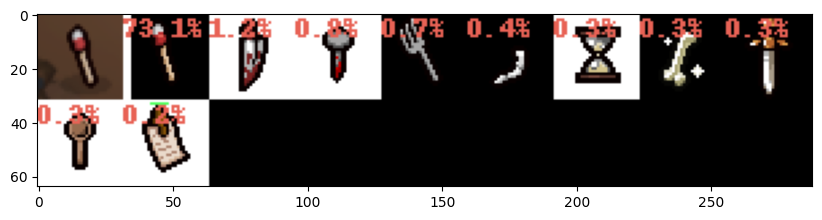


----------------------------------------------
real label:  test_00008.png
My Shadow 我的影子: 20.74%
Wooden Cross 木十字架: 6.28%
Growth Hormones 生长激素: 4.07%
Chaos 混沌: 2.78%
Synthoil 合成油脂: 2.58%
Speed Ball 混合麻药: 1.83%
Judas' Shadow 犹大的影子: 1.73%
Roid Rage 过量类固醇: 1.4%
The Virus 病毒: 1.1%
Doctor's Remote 胎儿博士的遥控器: 1.1%


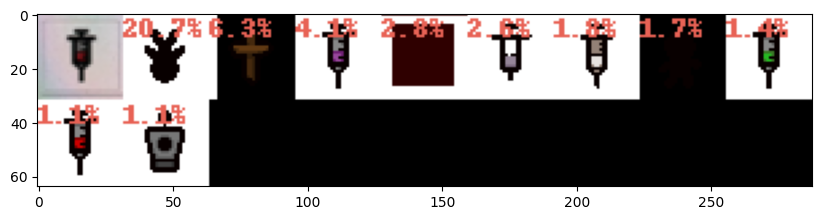


----------------------------------------------
real label:  test_00009.png
BBF 大美蝇: 20.92%
Mom's Perfume 妈妈的香水: 3.0%
Locust of War 战争蝗虫: 2.87%
Esau Jr. 小以扫: 2.64%
Compound Fracture 复杂性骨折: 2.39%
Spiderbaby 蜘蛛宝宝: 1.34%
Technology 2 科技II: 1.25%
Speed Ball 混合麻药: 1.15%
Plum Flute 糖梅溜溜笛: 1.06%
Sack Head 福袋头: 0.94%


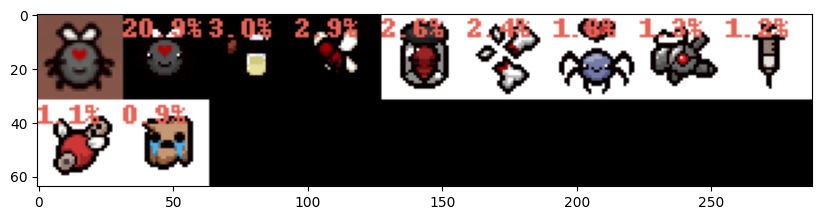


----------------------------------------------
real label:  test_00021.png
Polydactyly 多指畸形: 91.69%
Linger Bean 流连豆: 0.32%
Lost Contact 丢失的隐形眼镜: 0.28%
Mom's Toenail 妈妈的脚趾甲: 0.26%
Flush! 冲水！: 0.16%
1up! 1UP!: 0.16%
God's Flesh 神体蘑菇: 0.14%
Blank Card 空白卡牌: 0.14%
Safety Cap 保险瓶盖: 0.13%
Gigante Bean 巨豆: 0.12%


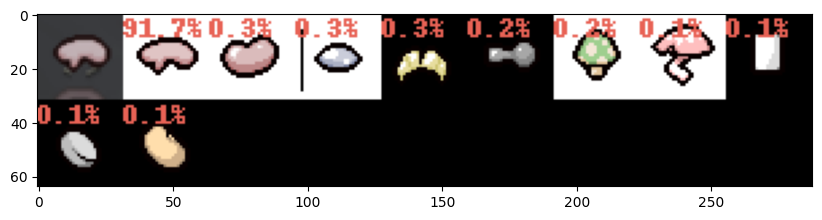


----------------------------------------------


In [41]:
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont

real_test_images = [i for i in os.listdir("cus_test_data/") if i.find(".") != 0]
print(len(real_test_images))

for t_image_path in real_test_images:
    print("real label: ", t_image_path.split("/")[-1])    
    
    t_image_path = os.path.join("cus_test_data", t_image_path)
    t_image = Image.open(t_image_path)
    t_image = t_image.resize((32, 32))
    result, predicted = eval_predict(model, t_image_path)

    probabilities = F.softmax(result, dim=1)  

    values, indices = torch.topk(probabilities, 10) # 使用topk获取最大的值及其索引
    match_images = [t_image]
    for p, i in zip(values[0].tolist(), indices[0].tolist()):
        data = get_real_label(i)
        print(f"{data['en']} {data['zh']}: {round(100*p, 2)}%")
        
        match_img = Image.open(data.get("image"))
        # 创建一个可以在给定图像上绘图的对象
        draw = ImageDraw.Draw(match_img)
        # 定义要使用的字体和大小
#         font = ImageFont.truetype(size=1)
        # 字体颜色
        font_color = (232,98,85)
        # 绘制文本
        draw.text((0, 0), f"{round(100*p, 1)}%", fill=font_color)
#         draw.text((10, 10), f"{round(100*p, 2)}%", font=font, fill=font_color)

                               
        match_images.append(match_img)
        
    plot_images(match_images, figsize=(10, 10))
    print()

    print("----------------------------------------------")
#     break

## vggNet用本地的图片进行测试

上面我保存到mps 中执行的保存, 所以后面也需要使用mps才可以? 或者转换成onnx 统一的格式

In [ ]:
model_list = [i for i in os.listdir("./") if i.find("20240128_full_32x32_clear_906class_l2__vgg16_")!= -1]
model_list.sort(key=lambda x: float(x.split("_")[-1].split(".pth")[0]))
model_list

In [ ]:
# model_path = "20240128_full_32x32_clear_906class_l2__vgg16_9_92.647.pth"  # 这个效果还不错
model_path = "20240128_full_32x32_clear_906class_l2__vgg16_21_96.852.pth"  # 这个不行, 明显过拟合了

model_path = "model/20240128_full_32x32_clear_906class_l2_2-_vgg16_16_98.001.pth"  # 这个效果也不错 19, 看第一/第二个

# model_path = "20240128_full_32x32_clear_906class_l2_2-_vgg16_17_98.277.pth"   # 13 分,明显没有更好, 这个
# model_path = "20240128_full_32x32_clear_906class_l2_2-_vgg16_18_98.231.pth"

# model_path = "20240128_full_32x32_clear_906class_l2_2-_vgg16_15_97.886.pth"  # 这个也是19, 所以还是需要配置好验证集

# model_path = "20240128_full_32x32_clear_906class_l2_2-_vgg16_18_98.231.pth"


model = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本
model.load_state_dict(torch.load(model_path))  # 不用百分百的

def get_real_label(class_index):
    return label_dict[class_index]

def eval_predict(model, image_path):
    image = read_image(image_path, mode=torchvision.io.image.ImageReadMode.RGB)
    inner_transform = transforms.Compose(
    [
#         transforms.Resize((64, 64)), 
        transforms.Resize((32, 32)), 
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            global_mean,
            global_std
        )  # 对图片数据做正则化
    ])
    model.eval()
    timg = inner_transform(image)
    timg = timg.to(device)
    timg1 = timg.unsqueeze(0)
    result = model(timg1)
    _, predicted = torch.max(result, 1)
    get_real_label(predicted.item())
    return result, predicted

import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont

real_test_images = [i for i in os.listdir("cus_test_data/") if i.find(".") != 0]
print(len(real_test_images))

for t_image_path in real_test_images:
    print("real label: ", t_image_path.split("/")[-1])    
    
    t_image_path = os.path.join("cus_test_data", t_image_path)
    t_image = Image.open(t_image_path)
    t_image = t_image.resize((32, 32))
    result, predicted = eval_predict(model, t_image_path)

    probabilities = F.softmax(result, dim=1)  

    values, indices = torch.topk(probabilities, 10) # 使用topk获取最大的值及其索引
#     print("最大的5个值:", values)
#     print("对应的索引:", indices.tolist())
    match_images = [t_image]
    for p, i in zip(values[0].tolist(), indices[0].tolist()):
        data = get_real_label(i)
        print(f"{data['en']} {data['zh']}: {round(100*p, 2)}%")
        
        match_img = Image.open(data.get("image"))
        # 创建一个可以在给定图像上绘图的对象
        draw = ImageDraw.Draw(match_img)
        # 定义要使用的字体和大小
#         font = ImageFont.truetype(size=1)
        # 字体颜色
        font_color = (232,98,85)
        # 绘制文本
        draw.text((0, 0), f"{round(100*p, 1)}%", fill=font_color)
#         draw.text((10, 10), f"{round(100*p, 2)}%", font=font, fill=font_color)

                               
        match_images.append(match_img)
        
    plot_images(match_images, figsize=(10, 10))
    print()

    print("----------------------------------------------")
#     break

# 批量测试验证

In [ ]:
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont

real_test_images = [i for i in os.listdir("cus_test_data/") if i.find(".") != 0]
print(len(real_test_images))

for t_image_path in real_test_images:
    print("real label: ", image_path.split("/")[-1])    
    
    t_image_path = os.path.join("cus_test_data", t_image_path)
    t_image = Image.open(t_image_path)
    t_image = t_image.resize((32, 32))
    result, predicted = eval_predict(model, t_image_path)

    probabilities = F.softmax(result, dim=1)  

    values, indices = torch.topk(probabilities, 10) # 使用topk获取最大的值及其索引
#     print("最大的5个值:", values)
#     print("对应的索引:", indices.tolist())
    match_images = [t_image]
    for p, i in zip(values[0].tolist(), indices[0].tolist()):
        data = get_real_label(i)
        print(f"{data['en']} {data['zh']}: {round(100*p, 2)}%")
        
        match_img = Image.open(data.get("image"))
        # 创建一个可以在给定图像上绘图的对象
        draw = ImageDraw.Draw(match_img)
        # 定义要使用的字体和大小
#         font = ImageFont.truetype(size=1)
        # 字体颜色
        font_color = (232,98,85)
        # 绘制文本
        draw.text((0, 0), f"{round(100*p, 1)}%", fill=font_color)
#         draw.text((10, 10), f"{round(100*p, 2)}%", font=font, fill=font_color)

                               
        match_images.append(match_img)
        
    plot_images(match_images, figsize=(10, 10))
    print()

    print("----------------------------------------------")
#     break

## 模型导出, 并且部署到安卓端

或者直接这儿做成一个服务

In [ ]:
# 生成成串的图片用来做背景图

image_dir = "/Users/zhengyiming/PycharmProjects/Isaac/cus_data"
images = os.listdir(image_dir)
images.sort(key=lambda x: f'{int(x.split(".")[0]):03}')
# images

In [ ]:
read_images = [Image.open(os.path.join("cus_data/", i)) for i in images if int(i.split(".")[0]) < 40]

result_image = plot_images(read_images, images_per_row=20, figsize=(20,20))
result_image

In [ ]:
image_dir = "/Users/zhengyiming/PycharmProjects/Isaac/new_cus_data"
images = os.listdir(image_dir)
images.sort(key=lambda x: f'{int(x.split(".")[0]):03}')
images

read_images = [Image.open(os.path.join("new_cus_data/", i)) for i in images if int(i.split(".")[0]) < 1]

result_image = plot_images(read_images, images_per_row=20, figsize=(25,25))
result_image

In [ ]:
image = Image.open("/Users/zhengyiming/PycharmProjects/Isaac/cus_data/3.png")
image

In [ ]:
image = image.resize((128, 128), Image.NONE)
image.save("128x128_indexhead.png")